In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import greycomatrix, greycoprops
from sklearn.cluster import MeanShift,estimate_bandwidth

In [349]:
def read_image(img_name):
    img_bgr = cv2.imread("../"+img_name+".jpg")
    h, w = img_bgr.shape[:2]
    scale = (640 * 480 / (w * h)) ** 0.4
    img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
    img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
    return img_rgb, img_gray

In [409]:
img_rgb1, img_gray1 = read_image("pengin")
img_rgb2, img_gray2 = read_image("chao")
img_rgb3, img_gray3 = read_image("akita")
img_rgb4, img_gray4 = read_image("ozu")

AttributeError: 'NoneType' object has no attribute 'shape'

# 10-1 領域処理のための特徴量
## 10-1-1 領域のテクスチャ
---
繰り返しの輝度パターンを**テクスチャ**と呼ぶ。
コンピュータがテクスチャを扱うためにはその特徴量を数値化する必要がある。

## 10-1-2 2次元フーリエ変換による周波数特徴量
---
2次元フーリエ変換の結果$F(u,v)$を用いて、パワースペクトル$p(u,v)$、その極座標$p(r,\theta)$を求める。  
さらに、幅$\Delta\theta$を持つ角度\thetaの扇状領域$p(\theta)$と、幅$\Delta r$を持つ半径$r$の同心円状領域$p(r)$を、以下の式により求める。
$$
    p(\theta)=\sum_{\theta'=\theta-\frac{\Delta\theta}{2}}^{\theta+\frac{\Delta\theta}{2}}\sum_{r=0}^{\infty}p(\theta',r)\\
    p(r)=\sum_{r'=r-\frac{\Delta r}{2}}^{r+\frac{\Delta r}{2}}\sum_{\theta=0}^{2\pi}p(\theta,r')
$$

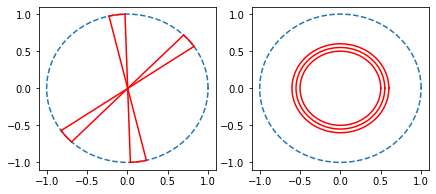

In [42]:
theta = np.arange(0,2*np.pi+0.01, 0.01)

x=np.cos(theta)
y=np.sin(theta)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].plot(x, y, '--');
ax[0].plot([x[375], x[60]], [y[375], y[60]], 'red');
ax[0].plot([x[395], x[80]], [y[395], y[80]], 'red');
ax[0].plot(x[60:81], y[60:81], 'red');
ax[0].plot(x[375:396], y[375:396], 'red');

ax[0].plot([x[475], x[160]], [y[475], y[160]], 'red');
ax[0].plot([x[495], x[180]], [y[495], y[180]], 'red');
ax[0].plot(x[160:181], y[160:181], 'red');
ax[0].plot(x[475:496], y[475:496], 'red');

ax[1].plot(x, y, '--');

ax[1].plot(x*10/20, y*10/20, 'red');
ax[1].plot(x*11/20, y*11/20, 'red');
ax[1].plot(x*12/20, y*12/20, 'red');

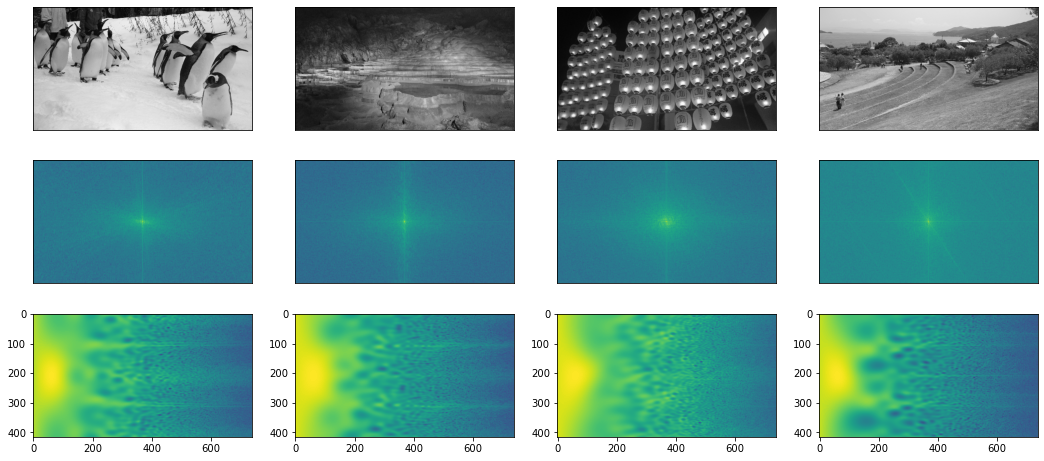

In [40]:
def make_power_sp(img):
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    return magnitude_spectrum

def make_polar_img(img):
    h = img.shape[0]
    w = img.shape[1]
    
    l = np.sqrt(w*w + h*h)
    m = l/np.log(l)

    center = (w/2, h/2)
    flags = cv2.INTER_LANCZOS4 + cv2.WARP_POLAR_LOG
    p_a = cv2.warpPolar(img, (w, h), center, m, flags)
    return p_a

fig, ax = plt.subplots(3, 4, figsize=(18, 8), subplot_kw=({"xticks":(), "yticks":()}))

imgs = np.array([img_gray1, img_gray2, img_gray3, img_gray4])

for i in range(4):
    ft_img = make_power_sp(imgs[i,:,:])
    p_img = make_polar_img(ft_img)
    
    ax[0][i].imshow(imgs[i,:,:], cmap = 'gray')
    ax[1][i].imshow(ft_img, cmap = 'viridis')
    ax[2][i].imshow(p_img, cmap = 'viridis')

## 10-1-3 ガボールフィルタによる局所周波数特性
---
**ガボールフィルタ**とは、正弦波・余弦波にガウス関数で窓をかけた関数のことである。  
パラメータを操作して様々な方向と強度を持つフィルタを多数準備して特徴抽出を行う。  
このフィルタ群を**フィルタバンク**と呼び、抽出された特徴量の群は**texton**である。  
2次元のガボールフィルタの式を以下に表す。
$$
    g(x,y,\lambda,\varphi)=\exp{(-\frac{x^2+y^2}{2\sigma^2})}\exp{(2\pi\lambda i(x\cos{\varphi}+y\sin{\varphi}))}
$$

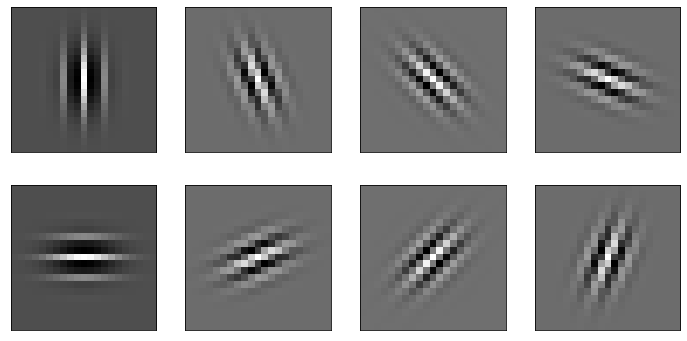

In [43]:
# cv2.getGaborKernel((ksize, sigma, theta, lambd, gamma, psi)
# ksize　フィルタのサイズ
# sigma　波の出てくる幅
# theta　角度
# lambd　波長
# gamma　広がり
# psi　位相

thetas = [0, -22.5, -45, -67.5, -90, -112.5, -135, -157.5]

fig, ax = plt.subplots(2, 4, figsize=(12, 6), subplot_kw=({"xticks":(), "yticks":()}))
for i in range(8):
    gabor = cv2.getGaborKernel((20, 20), 2, np.radians(thetas[i]), 3, 0.6, 0)
    ax[i//4][i%4].imshow(gabor, 'gray')

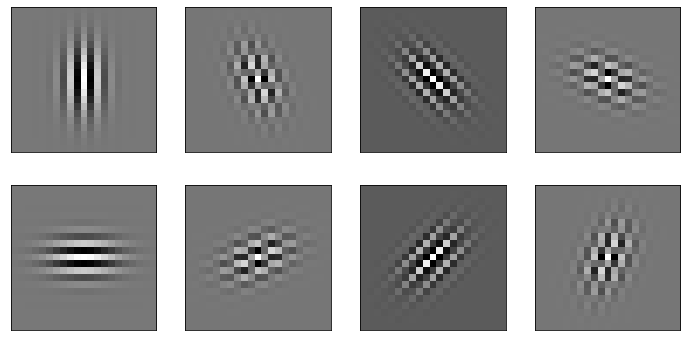

In [44]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), subplot_kw=({"xticks":(), "yticks":()}))
for i in range(8):
    gabor = cv2.getGaborKernel((20, 20), 2, np.radians(thetas[i]), 2, 0.6, 0)
    ax[i//4][i%4].imshow(gabor, 'gray')

NameError: name 'img_gray4' is not defined

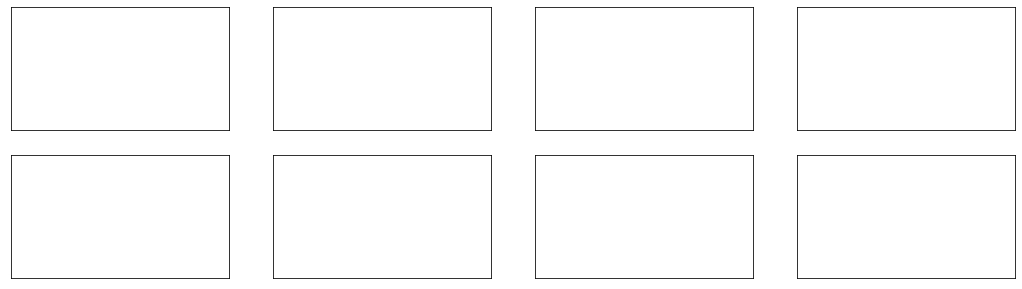

In [408]:
fig, ax = plt.subplots(2, 4, figsize=(18, 5), subplot_kw=({"xticks":(), "yticks":()}))
sum_img = np.zeros(img_gray4.shape)
for i in range(8):
    gabor = cv2.getGaborKernel((20, 20), 2, np.radians(thetas[i]), 3, 0.6, 0)
    dst = cv2.filter2D(img_gray4, -1, gabor)
    sum_img += dst
    ax[i//4][i%4].imshow(dst, 'gray')

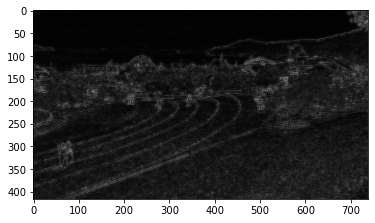

In [55]:
plt.imshow(sum_img, 'gray')

## 10-1-4 同時生起行列を用いた統計的特徴量
---
テクスチャの統計的特徴量を求めるために、**同時生起行列**を用いる方法がある。  
これは、離れた2つの場所にある画素対の値から、画素値の一様性、方向性、コントラストなどの性質を表す特徴量を求めるものである。  
ある画素$i$と、$i$から離れた位置にある画素$j$の画素対を考え、画素$i$と画素$j$の相対的な位置を$\delta=<d,\theta>$とする。  
それぞれの画素値を$L_{i}$、$L_{j}$とし、画素値の対$(L_{i},L_{j})$が生じる出現頻度で、ある同時生起行列$\boldsymbol{H_{\delta}}(L_{i},L_{j})$を考える。  
ここで、出現頻度$\boldsymbol{H_{\delta}}(L_{i},L_{j})$を正規化し、確率に変換した同時生起行列を$\boldsymbol{P_{\delta}}(L_{i},L_{j})$とする。  
ディジタル画像では、$\delta=<d,\theta>$は離散的な値を取り、$d=1$の場合、$\theta$がとりうる値は、0°,45°,90°,135°,180°,225°,270°,315°となる。  
点対称の関係も同じものとみなすと、$\theta$がとりうる値は、0°,45°,90°,135°となる。
同時生起行列の例を示す。
以下のような2値画像の場合、
$$
    \left[\begin{array}{cccc}
    1&0&0&1\\
    0&1&0&0\\
    0&1&0&1\\
    1&0&1&1
    \end{array}\right]
$$
$\boldsymbol{H}<1,0°>$は、
$$
    \left[\begin{array}{cc}
    4&9\\
    9&2
    \end{array}\right]
$$
のようになる。ここで、縦方向は画素$j$の値であり上から0,1、横方向は画素$i$の値であり左から0,1に対応している。

In [79]:
glcmWindow = np.array([[1, 0, 0, 1],
                       [0, 1, 0, 0],
                       [0, 1, 0, 1],
                       [1, 0, 1, 1]], dtype=np.uint8)

### 主な特徴量
同時生起行列を用いて計算する主な特徴量に、以下の7種類がある。ここで、$L$は画素値のレベルを表す。  

エネルギー：$$ENR=\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}\{P_{\sigma}(L_{i},L_{j})\}^2$$  
コントラスト：$$CNT=\sum_{k=0}^{L-1}k^2P_{x-y}(k)$$  
相関：$$CRR=\frac{\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}L_{i}L_{j}P_{\sigma}(L_{i},L_{j})-\mu_{x}\mu_{y}}{\sigma_{x}\sigma_{y}}$$  
分散：$$VAR=\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}(L_{i}-\mu_{x})^2P_{\sigma}(L_{i},L_{j})$$  
エントロピー：$$EPY=-\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}P_{\sigma}(L_{i},L_{j})\log{\{P_{\sigma}(L_{i},L_{j})\}}$$  
サムエントロピー：$$SEP=-\sum_{k=0}^{2L-2}P_{x+y}(k)\log{\{P_{x+y}(k)\}}$$  
逆差分モーメント：$$IDM=\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}\frac{1}{1+(L_{i}-L_{j})^2}P_{\sigma}(L_{i},L_{j})$$  
ただし、
$$
    \mu_{x}=\sum_{L_{i}=0}^{L-1}L_{i}P_{x}(L_{i}),\quad \mu_{y}=\sum_{L_{j}=0}^{L-1}L_{j}P_{y}(L_{j})\\
    \delta_{x}^2=\sum_{L_{i}=0}^{L-1}(L_{i}-\mu_{x})^2P_{x}(L_{i}),\quad \delta_{y}^2=\sum_{L_{j}=0}^{L-1}(L_{j}-\mu_{y})^2P_{y}(L_{j})\\
    P_{x}(L_{i})=\sum_{L_{j}=0}^{L-1}P_{\sigma}(L_{i},L_{j}),\quad P_{y}(L_{j})=\sum_{L_{i}=0}^{L-1}P_{\sigma}(L_{i},L_{j})\\
    P_{x-y}(k)=\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}P_{\sigma}(L_{i},L_{j}) \quad ただし、|L_{i}-L_{j}|=kを満たす\\
    P_{x+y}(k)=\sum_{L_{i}=0}^{L-1}\sum_{L_{j}=0}^{L-1}P_{\sigma}(L_{i},L_{j}) \quad ただし、|L_{i}+L_{j}|=kを満たす
$$

scikit-imageを用いた計算例を示す。

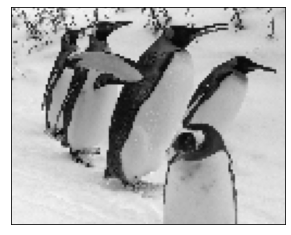

In [122]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/penguins1.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.8
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_bgr_resize = img_bgr_resize[20:120,120:260,:]
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, 'gray');
plt.xticks([]);
plt.yticks([]);

In [111]:
from skimage.feature import greycomatrix, greycoprops

def make_glcm_features(input_image, feature):
    glcm_feature = np.zeros((input_image.shape[0], input_image.shape[1]))

    for i in range(input_image.shape[0] ):
        #if i % 10 == 0:
        #    print(i)
        for j in range(input_image.shape[1] ):
            # 境界値処理
            if i <3 or j <3 or i > input_image.shape[0] - 4 or j > input_image.shape[1] - 4:
                glcm_feature[i,j]= 0
                continue
            # 7x7のウィンドウで画像を切り取る
            glcmWindow = input_image[i-3: i+4, j-3 : j+4]
            # 0度と90度の同時生起行列を計算する
            glcm_x = greycomatrix(glcmWindow, [1], [0], levels=256, symmetric=True)
            glcm_y = greycomatrix(glcmWindow, [1], [90], levels=256, symmetric=True)
            # テクスチャ特徴量を計算
            texture_feature_x = greycoprops(glcm_x, feature)
            texture_feature_y = greycoprops(glcm_y, feature)
            glcm_feature[i,j] = (texture_feature_x + texture_feature_y)/2
    return glcm_feature

feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'ASM', 'correlation']

glcm_feature = np.array([make_glcm_features(img_gray, feature_name) for feature_name in feature_names])

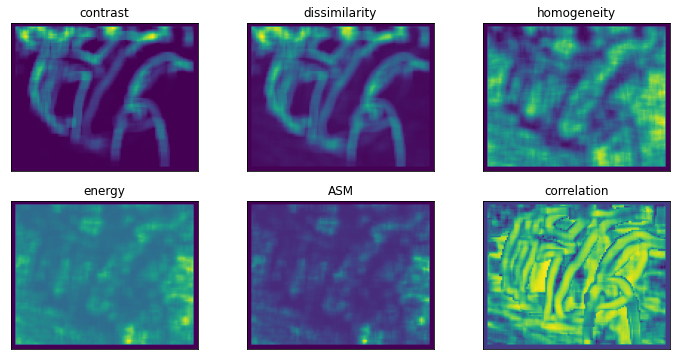

In [123]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6), subplot_kw=({"xticks":(), "yticks":()}))
for i in range(6):
    ax[i//3][i%3].imshow(glcm_feature[i])
    ax[i//3][i%3].set_title(feature_names[i])

# 10-2 領域分割処理
## 10-2-1 領域分割処理のアプローチ
---
画像上で近傍の画素を特徴量に基づいて、階層的に統合する方法、画素の持つ属性値のパラメータ空間でクラスタリングする方法などがある。
## 10-2-2 隣接画素の階層的な統合による領域分割処理
---
類似した特徴量を持ち空間的に隣接した画素の集合に画像を分割する代表的な手法が**領域統合法**である。
1. ラスタスキャンによって、ラベルの付いていない画素を注目画素とし、新しくラベルを付ける。
2. 注目画素の4(8)近傍で、同じ画素があれば注目画素と同じラベルを付ける。
3. 新しくラベルを付けた画素を注目画素として、2の処理を行う。
4. 2の操作で新しくラベルを付ける画素がなければ、1の処理に戻る。
5. すべての画素にラベルが付いたところで処理を終了する。
6. 同じラベルを持つ画素の画素値の、平均値を全て求める。
7. すべての未処理のラベルを持つ画素の集合および、統合されていない画素の集合に対して、隣接する画素の集合のなかで、  
上記平均値の差分が最小の画素の集合と統合し、新しいラベルを統合された領域のすべての画素に付ける。  
8. すべての画素の集合を未処理のラベルとして、6~8の処理を繰り返す。

## 10-2-3 画素特徴量のパラメータ空間でのクラス分けによる領域分割処理
---
画素の空間的な位置関係を全く考慮せず、画素単位に特徴量を計算し、画素単位でクラス分けする。  
詳しくは**12パターン認識**で説明する。

## 10-2-4 画素特徴を効率よくクラス分けするミーンシフト
---
ここでは、ミーンシフト法を用いた画像の領域分割の例を示す。

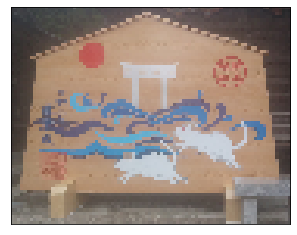

In [249]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/oarai.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.9
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_bgr_resize = img_bgr_resize[5:75,38:128,:]
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

<ipython-input-182-004efd28fe54>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(122, projection='3d')


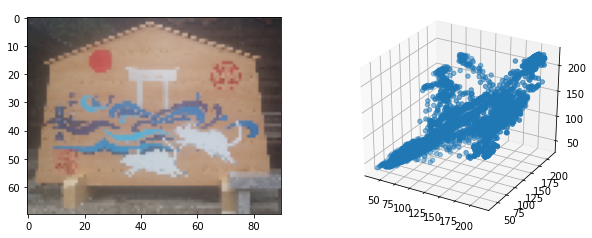

In [182]:
from mpl_toolkits.mplot3d import Axes3D
rgb_img = img_rgb.copy()

fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)

plt.subplot(1, 2, 2)
ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(rgb_img[:,:,0], rgb_img[:,:,1], rgb_img[:,:,2])

In [183]:
import pandas as pd

rgb0 = rgb_img[:,:,0]
rgb1 = rgb_img[:,:,1]
rgb2 = rgb_img[:,:,2]
x1 = range(0,rgb_img.shape[1])
x2 = range(0,rgb_img.shape[0])
x1, x2 = np.meshgrid(x1,x2)

rgb = np.array([rgb0, rgb1, rgb2, x1, x2]).reshape(5,rgb_img.shape[0]*rgb_img.shape[1])
df = pd.DataFrame(rgb.T)
df.columns = ['red', 'green', 'blue', 'x1', 'x2']
df.head()

,red,green,blue,x1,x2
0,55,58,65,0,0
1,62,65,70,1,0
2,64,65,70,2,0
3,65,68,73,3,0
4,58,61,68,4,0


In [169]:
x1.flatten()

array([ 0,  1,  2, ..., 97, 98, 99])

In [214]:
from sklearn import cluster

# k-means
km=cluster.KMeans(n_clusters=5)
z_km=km.fit(df)

# MeanShift
bwidth = estimate_bandwidth(df.values,quantile=0.15,n_samples=200)
ms = cluster.MeanShift(seeds=df.values, bandwidth=bwidth)
ms.fit(df.values)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)

[[182.02166437 150.25137552 127.30777166  44.7843879   33.77751032]
 [ 83.85361973  75.70564837  73.0230708   30.25616547  24.1646778 ]
 [114.92842942 106.90357853 105.15506958  38.78429423  56.10139165]
 [197.32758621 192.68103448 192.44827586  51.17241379  36.73275862]]


In [ ]:
estimate_bandwidth(df.values,quantile=0.15,n_samples=500)

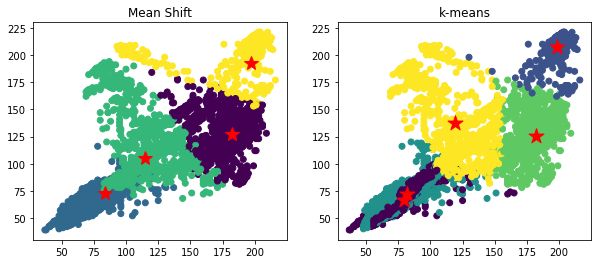

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(df["red"], df["blue"], c=labels)
for i in range(len(cluster_centers)):
    ax[0].plot(cluster_centers[i,0], cluster_centers[i,2], marker='*',c='red', markersize=14)
ax[0].set_title("Mean Shift");

ax[1].scatter(df["red"], df["blue"], c=z_km.labels_)
ax[1].scatter(z_km.cluster_centers_[:,0],z_km.cluster_centers_[:,2],s=250, marker='*',c='red')
ax[1].set_title("k-means");

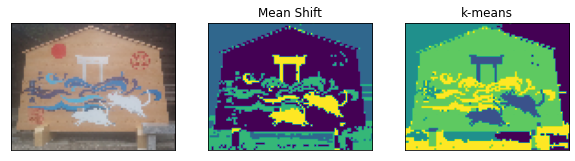

In [216]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), subplot_kw=({"xticks":(), "yticks":()}))

ax[0].imshow(rgb_img)
ax[1].imshow(labels.reshape(rgb_img.shape[0],rgb_img.shape[1]))
ax[1].set_title("Mean Shift");
ax[2].imshow(z_km.labels_.reshape(rgb_img.shape[0],rgb_img.shape[1]))
ax[2].set_title("k-means");

## 10-2-5 対象物と背景の間のエッジを利用した領域分割処理
---
対象領域がエッジで禍根れているときは、エッジを閉曲線として抽出する**スネーク（動的輪郭モデル）**によって領域分割が行える。  
スネークは、対象物体を囲む閉曲線を初期値として与え、徐々に閉曲線が縮んでいき、エッジの境界に張り付いていく。  
閉曲線のエネルギー$E_{S}$を以下のように定め、$E_{S}$が最小になるように閉曲線を求める。
$$
    E_{S}=\int_{0}^{1}E_{internal}(\nu(s))ds+\int_{0}^{1}E_{image}(\nu(s))ds+\int_{0}^{1}E_{external}(\nu(s))ds
$$
ただし、$\nu(s)$は$s(0\leq s\leq1)$を媒介変数とする閉曲線で$\nu(s)=(x(s),y(s))$である。  
$E_{internal}$は、閉曲線の連続性や滑らかさを表すエネルギー  
$E_{image}$は、画像のエッジの強度に基づくエネルギー  
$E_{external}$は、ユーザーが望むような任意のエネルギーを付加するための項である。  
$E_{internal}$は、連続性のエネルギー$E_{continuity}$と、滑らかさのエネルギー$E_{curvature}$の加重和で、以下のように表される。  
$$
    E_{internal}=\alpha E_{continuity}(\nu(s))+\beta E_{curvature}(\nu(s))
$$
$E_{continuity}=|d\nu/ds|^2$は、$\nu(s)$の1次微分値の2乗であり、閉曲線の長さを短くしようとする。  
$E_{curvature}=|d^2\nu/ds^2|^2$は、$\nu(s)$の2次微分値の2乗であり、閉曲線の滑らかさを表す。  
$\alpha$と$\beta$はそれぞれエネルギーの重みである。  
$E_{image}$はエッジのある場所で小さくなり、$E_{image}=-|\nabla I(\nu(s))|$である。  

In [ ]:
from skimage.segmentation import active_contour
from skimage.filters import gaussian

s = np.linspace(0, 2*np.pi, 400)
r = 280 + 120*np.sin(s)
c = 580 + 180*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img_gray2,3, preserve_range=False), init, alpha=0.015, beta=10, gamma=0.001)

plt.imshow(img_gray2)
plt.plot(snake[:,1],snake[:,0])
plt.plot(init[:, 1], init[:, 0])

## 10-2-6 グラフカットを用いた領域分割処理
---
ある画像において、あらかじめ対象と背景の一部の位置が与えられている条件下で、対象と背景には画素値に違いがあるという仮定のもとで、  
全画像を対象と背景の2種類にラベル付けする方法として、**グラフカット**がある。

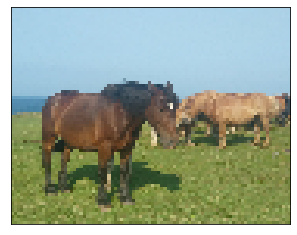

In [371]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/uma.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.9
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_bgr_resize = img_bgr_resize[5:75,38:128,:]
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

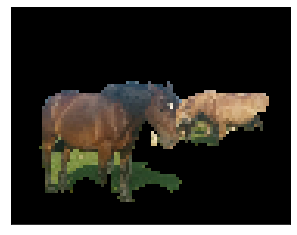

In [372]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = img_rgb.copy()

mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (5,10,80,55)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img);
plt.xticks([]);
plt.yticks([]);

## Watershedアルゴリズムを使った画像の領域分割

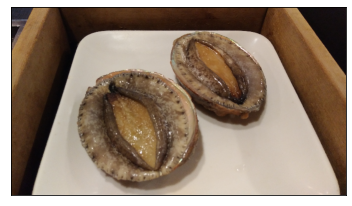

In [364]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/awabi.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.5
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

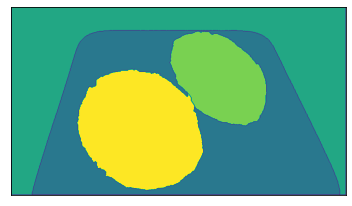

In [368]:
img = img_gray.copy()
img_rgb = img_rgb.copy()

ret, thresh = cv2.threshold(img,170,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv2.dilate(opening,kernel,iterations=3)

dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.28*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

markers = markers+1

markers[unknown==255] = 0

markers = cv2.watershed(img_rgb, markers)
img_rgb[markers == -1] = [255,0,0]
plt.imshow(markers)
plt.xticks([]);
plt.yticks([]);

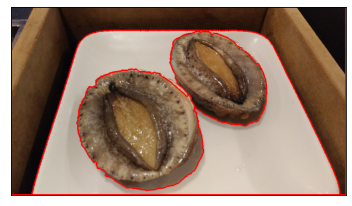

In [369]:
img_rgb2 = img_rgb.copy()
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:

        cv2.drawContours(img_rgb2, contours, i, (255, 0, 0), 1)

plt.imshow(img_rgb2);
plt.xticks([]);
plt.yticks([]);